In [1]:
import os


def getFilePaths(directory):
    filepaths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                filepaths.append(os.path.join(root, file))
    return filepaths


def getLabels(filepaths):
    labels = []
    for file in filepaths:
        labels.append(file.split('/')[2])
    return labels

In [2]:
import pandas as pd

train_files = getFilePaths('data/train')
train_labels = getLabels(train_files)
train_df = pd.DataFrame({'filepath': train_files, 'label': train_labels})
train_df.head()

,filepath,label
0,data/train/Paper/image_811.jpg,Paper
1,data/train/Paper/image_805.jpg,Paper
2,data/train/Paper/image_193.jpg,Paper
3,data/train/Paper/image_187.jpg,Paper
4,data/train/Paper/image_839.jpg,Paper


In [3]:
test_df = pd.DataFrame({'filepath': getFilePaths('data/test'), 'label':
    ['test' for i in range(len(getFilePaths('data/test')))]})
test_df.head()

,filepath,label
0,data/test/test_image_1159.jpg,test
1,data/test/test_image_588.jpg,test
2,data/test/test_image_1165.jpg,test
3,data/test/test_image_1171.jpg,test
4,data/test/test_image_239.jpg,test


In [28]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2,
    #zoom_range=0.2,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255
)

## BUILDING MODEL

In [5]:
img_size = 100
batch_size = 32
epochs = 100

In [6]:
import keras
from keras import layers


def build_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
base_model_results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1": [],
    "history": []
}

In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(train_df):
    train_data = train_df.iloc[train_index]
    test_data = train_df.iloc[test_index]

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical'
    )

    model = build_model()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )

    base_model_results["history"].append(history)

    y_true = test_data['label']
    y_pred = model.predict(test_generator)

    y_pred_classes = np.argmax(y_pred, axis=1)
    class_indices_list = list(test_generator.class_indices.keys())

    y_pred_labels = [class_indices_list[i] for i in y_pred_classes]

    report = classification_report(y_true, y_pred_labels, output_dict=True)

    base_model_results["accuracy"].append(report["accuracy"])
    base_model_results["recall"].append(report["macro avg"]["recall"])
    base_model_results["precision"].append(report["macro avg"]["precision"])
    base_model_results["f1"].append(report["macro avg"]["f1-score"])

    print(report)

Found 2016 validated image filenames belonging to 3 classes.
Found 504 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Epoch 1/100


2023-12-06 07:50:15.606983: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 2s 32ms/step - loss: 0.8788 - accuracy: 0.5913 - val_loss: 0.8448 - val_accuracy: 0.6706
Epoch 2/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4494 - accuracy: 0.8433 - val_loss: 1.0351 - val_accuracy: 0.5873
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.3101 - accuracy: 0.8938 - val_loss: 0.5719 - val_accuracy: 0.7778
Epoch 4/100
63/63 [==============================] - 2s 30ms/step - loss: 0.2060 - accuracy: 0.9360 - val_loss: 0.6075 - val_accuracy: 0.7917
Epoch 5/100
63/63 [==============================] - 2s 30ms/step - loss: 0.1666 - accuracy: 0.9435 - val_loss: 0.3792 - val_accuracy: 0.8532
Epoch 6/100
63/63 [==============================] - 2s 30ms/step - loss: 0.1125 - accuracy: 0.9683 - val_loss: 0.4088 - val_accuracy: 0.8651
Epoch 7/100
63/63 [==============================] - 2s 34ms/step - loss: 0.0742 - accuracy: 0.9816 - val_loss: 0.3976 - val_accuracy: 0.8611
Epoch 8/100
63/63 

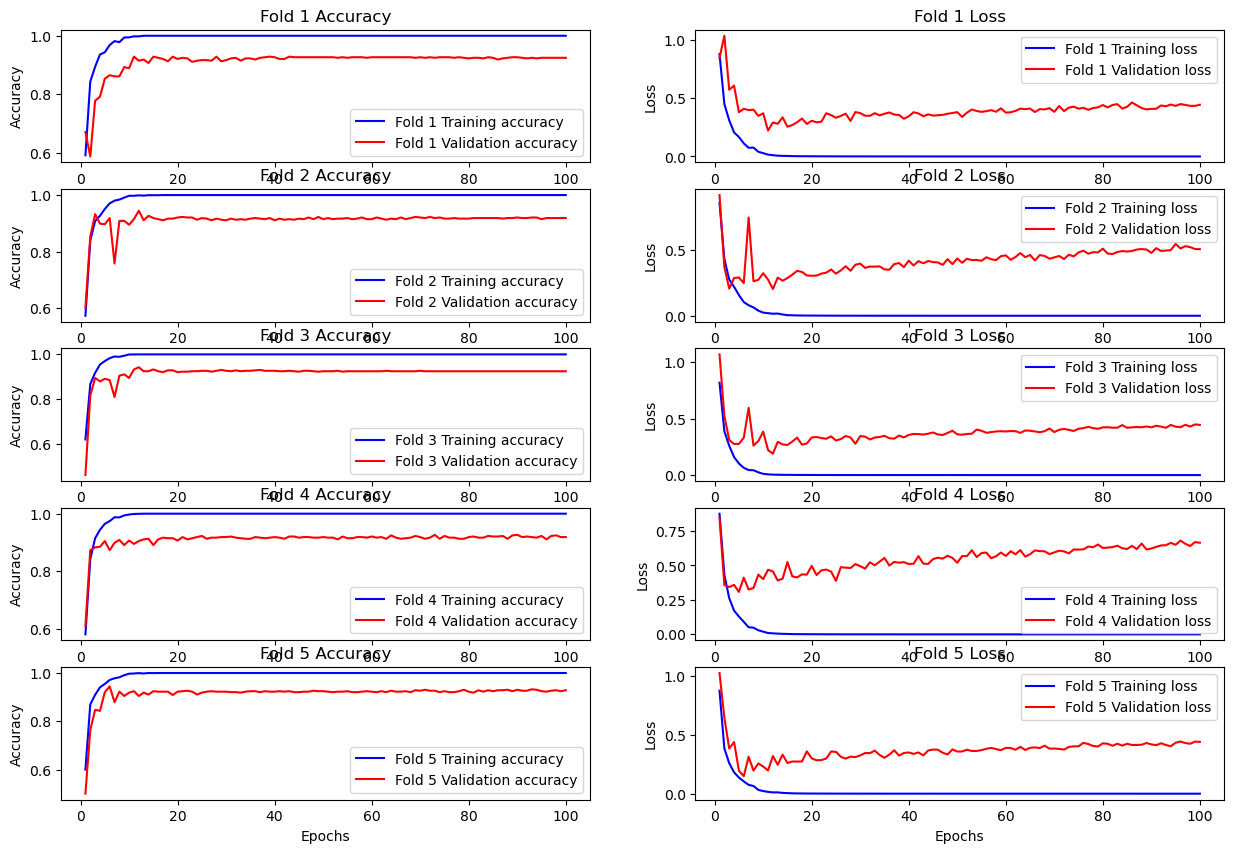

In [13]:
from matplotlib import pyplot as plt

epochs_fig = range(1, epochs + 1)
fig, axs = plt.subplots(5, 2, figsize=(15, 10))

for i, history in enumerate(base_model_results["history"]):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    axs[i, 0].plot(epochs_fig, train_acc, 'b', label=f'Fold {i + 1} Training accuracy')
    axs[i, 0].plot(epochs_fig, val_acc, 'r', label=f'Fold {i + 1} Validation accuracy')
    axs[i, 0].set_title(f'Fold {i + 1} Accuracy')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].legend()

    axs[i, 1].plot(epochs_fig, train_loss, 'b', label=f'Fold {i + 1} Training loss')
    axs[i, 1].plot(epochs_fig, val_loss, 'r', label=f'Fold {i + 1} Validation loss')
    axs[i, 1].set_title(f'Fold {i + 1} Loss')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].legend()


In [32]:
def build_advanced_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    custom_optimizer = tf.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
advanced_model_results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1": [],
    "history": []
}

In [16]:
batch_size = 128

for train_index, test_index in kf.split(train_df):
    train_data = train_df.iloc[train_index]
    test_data = train_df.iloc[test_index]

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical'
    )

    model = build_advanced_model()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )

    base_model_results["history"].append(history)

    y_true = test_data['label']
    y_pred = model.predict(test_generator)

    y_pred_classes = np.argmax(y_pred, axis=1)
    class_indices_list = list(test_generator.class_indices.keys())
    y_pred_labels = [class_indices_list[i] for i in y_pred_classes]

    report = classification_report(y_true, y_pred_labels, output_dict=True)

    advanced_model_results["accuracy"].append(report["accuracy"])
    advanced_model_results["recall"].append(report["macro avg"]["recall"])
    advanced_model_results["precision"].append(report["macro avg"]["precision"])
    advanced_model_results["f1"].append(report["macro avg"]["f1-score"])

    print(report)

Found 2016 validated image filenames belonging to 3 classes.
Found 504 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Epoch 1/100
16/16 [==============================] - 2s 109ms/step - loss: 1.0361 - accuracy: 0.4266 - val_loss: 1.7015 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 2s 102ms/step - loss: 1.0061 - accuracy: 0.4534 - val_loss: 1.8153 - val_accuracy: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 3s 162ms/step - loss: 0.9976 - accuracy: 0.4975 - val_loss: 1.8657 - val_accuracy: 0.0000e+00
Epoch 4/100
16/16 [==============================] - 2s 133ms/step - loss: 0.9918 - accuracy: 0.4752 - val_loss: 1.9067 - val_accuracy: 0.0000e+00
Epoch 5/100
16/16 [==============================] - 2s 117ms/step - loss: 0.9804 - accuracy: 0.5417 - val_loss: 1.8476 - val_accuracy: 0.0000e+00
Epoch 6/100
16/16 [==============================] - 2s 106ms/step - loss: 0.9691 - 

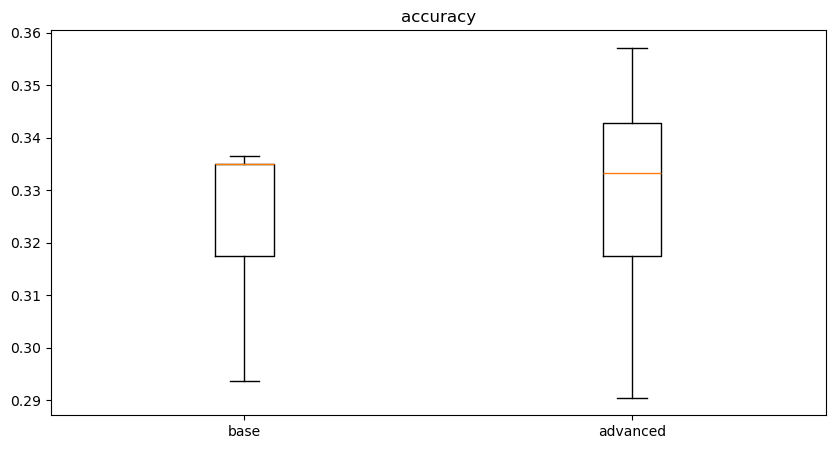

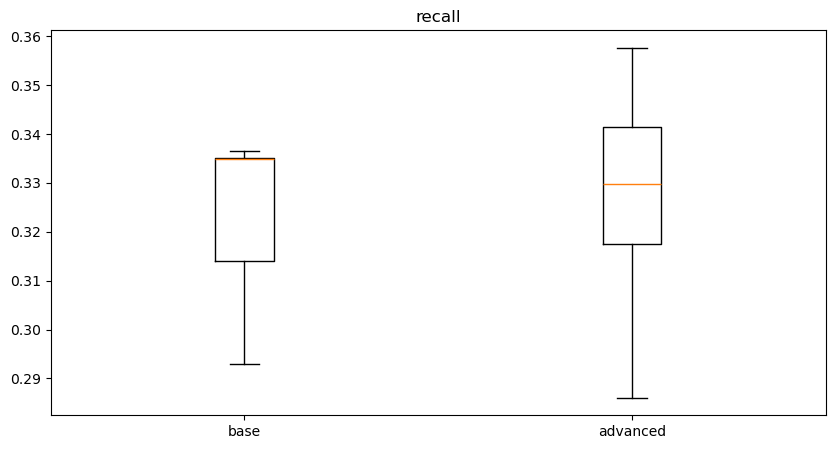

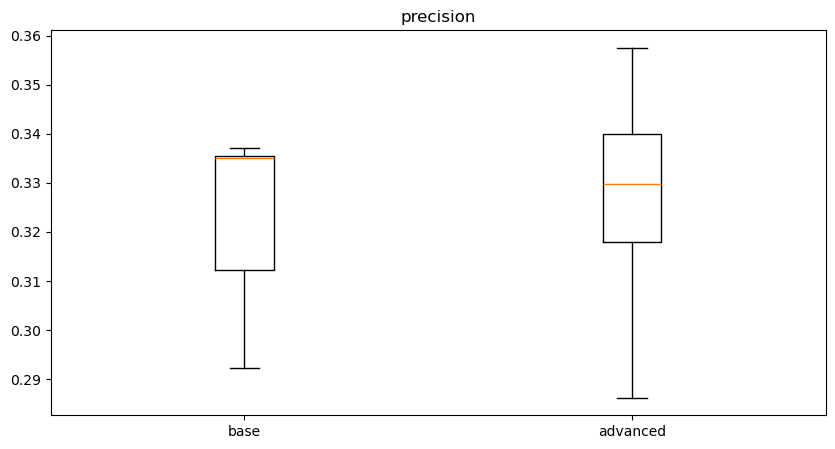

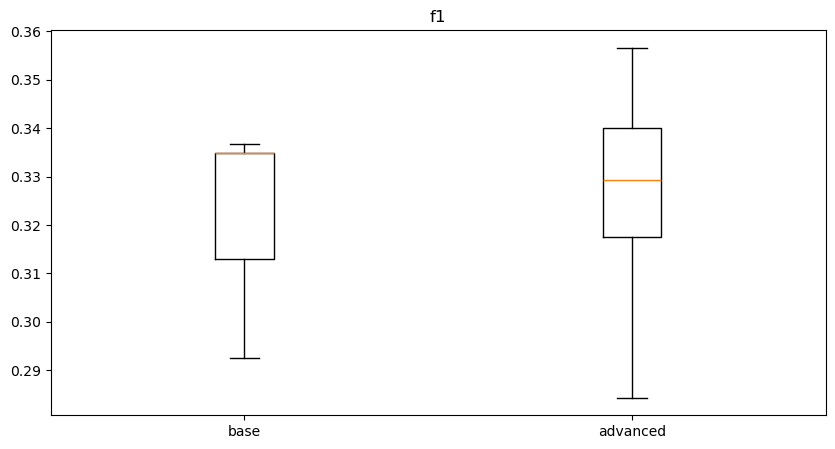

In [17]:
results = {
    "base": base_model_results,
    "advanced": advanced_model_results
}

metrics = ["accuracy", "recall", "precision", "f1"]
models = ["base", "advanced"]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.boxplot([results["base"][metric], results["advanced"][metric]], labels=models)
    plt.title(metric)
    plt.show()

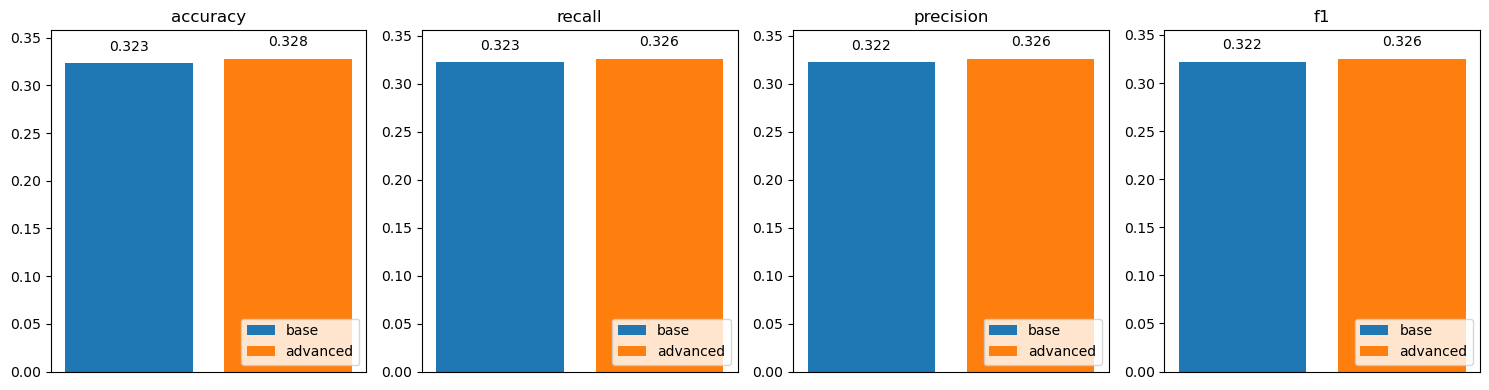

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')

    for j, model in enumerate(models):
        values = results[model][metric]

        if len(values) == 0:
            values = [0]

        avg = np.mean(values)

        if avg > max:
            max = avg

        ax.bar(j, avg, 0.8, label=model)
        ax.text(j, avg + 0.01, str(round(avg, 3)), ha='center', va='bottom')

    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    target_size=(img_size, img_size),
    shuffle=True,
    seed=1234,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    subset="validation",
    batch_size=batch_size,
    target_size=(img_size, img_size),
    shuffle=True,
    seed=1234,
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    batch_size=1,
    target_size=(img_size, img_size),
    shuffle=False,
    color_mode='grayscale'
)

model = build_model()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Average train accuracy: ", np.mean(train_acc))
print("Average train loss: ", np.mean(train_loss))
print("Average val accuracy: ", np.mean(val_acc))
print("Average val loss: ", np.mean(val_loss))

y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)
class_indices_list = list(train_generator.class_indices.keys())
print(class_indices_list)
y_pred_classes = [class_indices_list[i] for i in y_pred_classes]

Found 2520 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Found 1350 validated image filenames belonging to 1 classes.
Epoch 1/100
79/79 [==============================] - 3s 33ms/step - loss: 0.8082 - accuracy: 0.6274 - val_loss: 0.7240 - val_accuracy: 0.7270
Epoch 2/100
79/79 [==============================] - 3s 32ms/step - loss: 0.3692 - accuracy: 0.8667 - val_loss: 0.8888 - val_accuracy: 0.6635
Epoch 3/100
79/79 [==============================] - 2s 32ms/step - loss: 0.2545 - accuracy: 0.9159 - val_loss: 0.2283 - val_accuracy: 0.9111
Epoch 4/100
79/79 [==============================] - 2s 31ms/step - loss: 0.1867 - accuracy: 0.9337 - val_loss: 0.4724 - val_accuracy: 0.8460
Epoch 5/100
79/79 [==============================] - 3s 32ms/step - loss: 0.1110 - accuracy: 0.9639 - val_loss: 0.0526 - val_accuracy: 0.9841
Epoch 6/100
79/79 [==============================] - 3s 32ms/step - loss: 0.0652 - accuracy: 0.9802 - val_lo

In [21]:
data = {'image': test_df['filepath'].apply(lambda x: os.path.basename(x)), 'predicted_class': y_pred_classes}
df = pd.DataFrame(data=data)
df.head()

,image,predicted_class
0,test_image_1159.jpg,Rock
1,test_image_588.jpg,Rock
2,test_image_1165.jpg,Paper
3,test_image_1171.jpg,Scissors
4,test_image_239.jpg,Paper


In [22]:
df.to_csv('out/submission.csv', index=False)

In [46]:
def build_custom_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
  
    custom_optimizer = tf.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
import numpy as np
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    target_size=(img_size, img_size),
    shuffle=True,
    seed=1234,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    subset="validation",
    batch_size=batch_size,
    target_size=(img_size, img_size),
    shuffle=True,
    seed=1234,
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    batch_size=1,
    target_size=(img_size, img_size),
    shuffle=False,
    color_mode='grayscale'
)

model = build_custom_model()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Average train accuracy: ", np.mean(train_acc))
print("Average train loss: ", np.mean(train_loss))
print("Average val accuracy: ", np.mean(val_acc))
print("Average val loss: ", np.mean(val_loss))

y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)
class_indices_list = list(train_generator.class_indices.keys())
print(class_indices_list)
y_pred_classes = [class_indices_list[i] for i in y_pred_classes]


Found 2520 validated image filenames belonging to 3 classes.
Found 630 validated image filenames belonging to 3 classes.
Found 1350 validated image filenames belonging to 1 classes.
Epoch 1/100
79/79 [==============================] - 4s 42ms/step - loss: 1.0738 - accuracy: 0.4246 - val_loss: 1.9243 - val_accuracy: 0.0000e+00
Epoch 2/100
79/79 [==============================] - 3s 38ms/step - loss: 1.0220 - accuracy: 0.4238 - val_loss: 1.8318 - val_accuracy: 0.0000e+00
Epoch 3/100
65/79 [=======================>......] - ETA: 0s - loss: 1.0213 - accuracy: 0.4141

KeyboardInterrupt: 

In [42]:
import pandas as pd
data = {'image': test_df['filepath'].apply(lambda x: os.path.basename(x)), 'predicted_class': y_pred_classes}
df = pd.DataFrame(data=data)
df.head()

,image,predicted_class
0,test_image_1159.jpg,Rock
1,test_image_588.jpg,Rock
2,test_image_1165.jpg,Paper
3,test_image_1171.jpg,Scissors
4,test_image_239.jpg,Paper


In [43]:
df.to_csv('out/submission_bonus.csv', index=False)